In [55]:
!pip install pmdarima

## Occupancy analysis with `pmdarima`



In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.0


### Import the data



In [57]:
!git clone https://github.com/valwork2021/Hackathon.git

fatal: destination path 'Hackathon' already exists and is not an empty directory.


In [58]:
fileName = "cba_svlive_activity_by_hour_by_space_type_2021-03-10T2016.csv"
df_original = pd.read_csv('/content/Hackathon/data/' + fileName)
df_original

,Space Type Space Type Name,Cockpit,Desk: Hotdesk,Desk: Project Table,Desk: Standard
0,Svlive Activity By Hour Start of Hour Time,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes,Svlive Activity By Hour Active Minutes
1,12/10/2020 23:00,NaN,NaN,NaN,2
2,12/11/2020 0:00,NaN,NaN,NaN,439
3,12/11/2020 1:00,NaN,NaN,NaN,868
4,12/11/2020 2:00,NaN,NaN,NaN,945
...,...,...,...,...,...
686,1/8/2021 17:00,NaN,NaN,89,18110
687,1/8/2021 18:00,NaN,NaN,14,9217
688,1/8/2021 19:00,NaN,NaN,NaN,3952
689,1/8/2021 20:00,NaN,NaN,NaN,1851


In [59]:
df = pd.DataFrame()
df = df_original.iloc[1:, 4].astype(float)
df.fillna(0, inplace=True)

df

1          2.0
2        439.0
3        868.0
4        945.0
5        870.0
        ...   
686    18110.0
687     9217.0
688     3952.0
689     1851.0
690      387.0
Name: Desk: Standard, Length: 690, dtype: float64

### Split the data

We'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [60]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data.values
y_test = test_data.values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

552 train samples
138 test samples


### Pre-modeling analysis



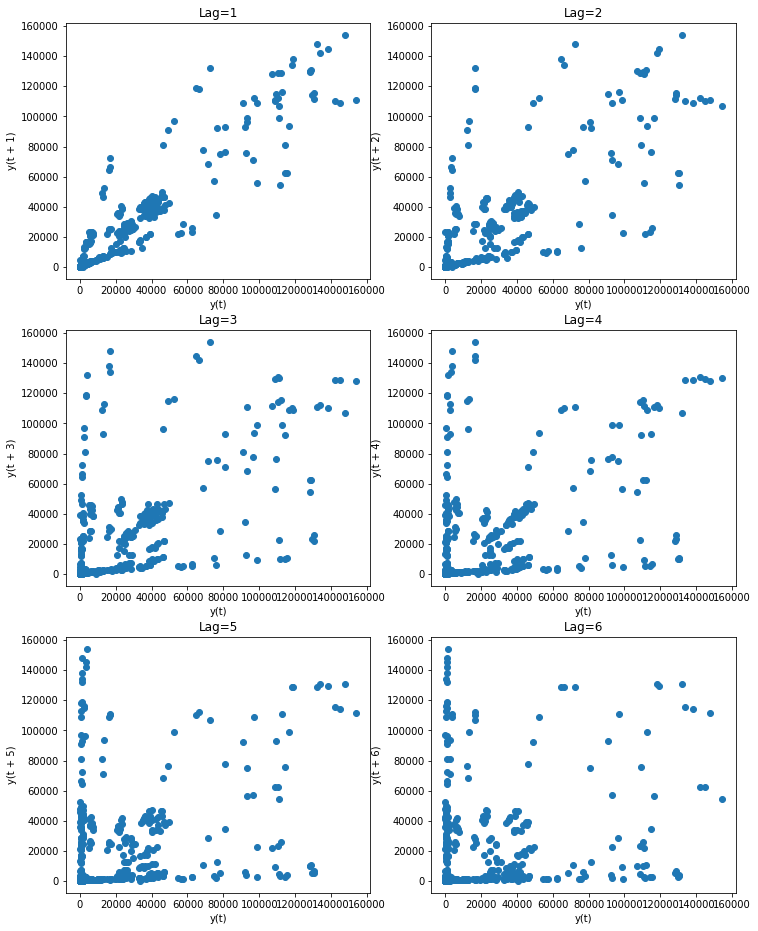

In [61]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [62]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


Use `auto_arima` to fit a model on the data.

In [63]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11330.683, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11788.057, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11520.174, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11495.311, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11786.058, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11424.004, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11442.745, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11317.779, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11441.918, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11372.334, Time=0.96 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11291.383, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11317.369, Time=1.04 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11291.156, Time=1.10 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=11268.117, Time=0.83 sec
 ARIMA(5,1,2)(0,0,0

In [64]:
print(auto.order)

(6, 1, 5)


In [65]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 11757815.097838258
SMAPE: 61.381114084571074


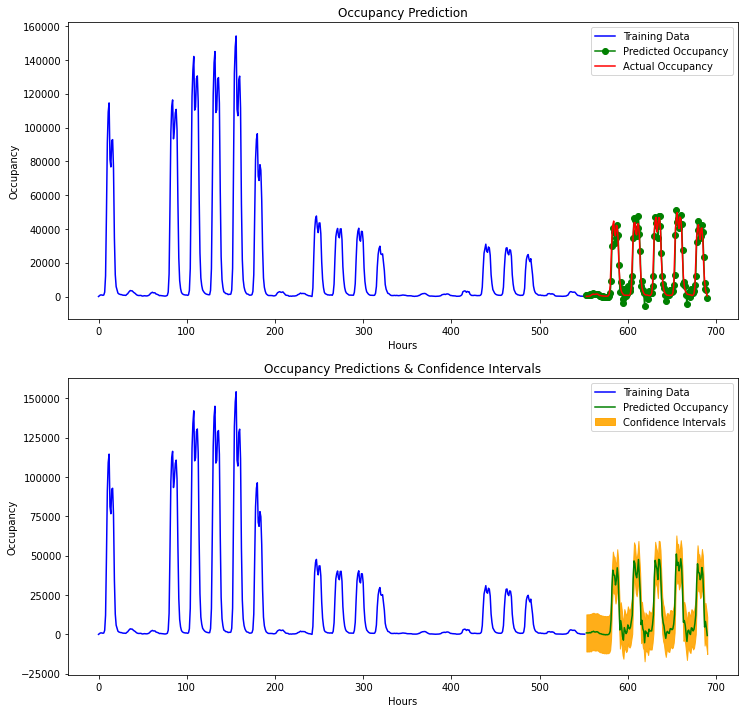

In [66]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Occupancy')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Occupancy')
axes[0].set_title('Occupancy Prediction')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Occupancy')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Occupancy')

axes[1].set_title('Occupancy Predictions & Confidence Intervals')
axes[1].set_xlabel('Hours')
axes[1].set_ylabel('Occupancy')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")
axes[1].legend()